<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/base_llm_eval_pca_scaling.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Standard Benchmark PC Analysis

This notebook shows the properties of LMs' benchmark performance with PC analysis, corresponding to the Sec 3.2 & 3.3 of the paper.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [ ]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()

Extract the benchmark metric field

In [4]:
metric_df = base_llm_benchmark_eval[ALL_BENCHMARK_METRIC_LIST]

## PC Analysis

Data imputation

In [5]:
impute_kwargs = DEFAULT_PCA_PREPROCESS_KWARGS['imputation_kwargs'].copy()
impute_kwargs['verbose'] = True
imputed_metric_df, _ = pca_impute(metric_df, **impute_kwargs)

Missing values in training data: 0.97%


PC measure extraction

In [6]:
pca, imputed_metric_pc, _ = perform_pca(imputed_metric_df, **DEFAULT_PCA_PREPROCESS_KWARGS['pca_kwargs']) 

In [7]:
base_llm_eval_pca = pd.concat([base_llm_benchmark_eval, imputed_metric_pc], axis=1)

Visualize the PCA explained variance ratio

/var/folders/5d/x568cvhj5yn1x8sv5twbhbxm0000gn/T/ipykernel_88855/267239835.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(1, n_components+1))


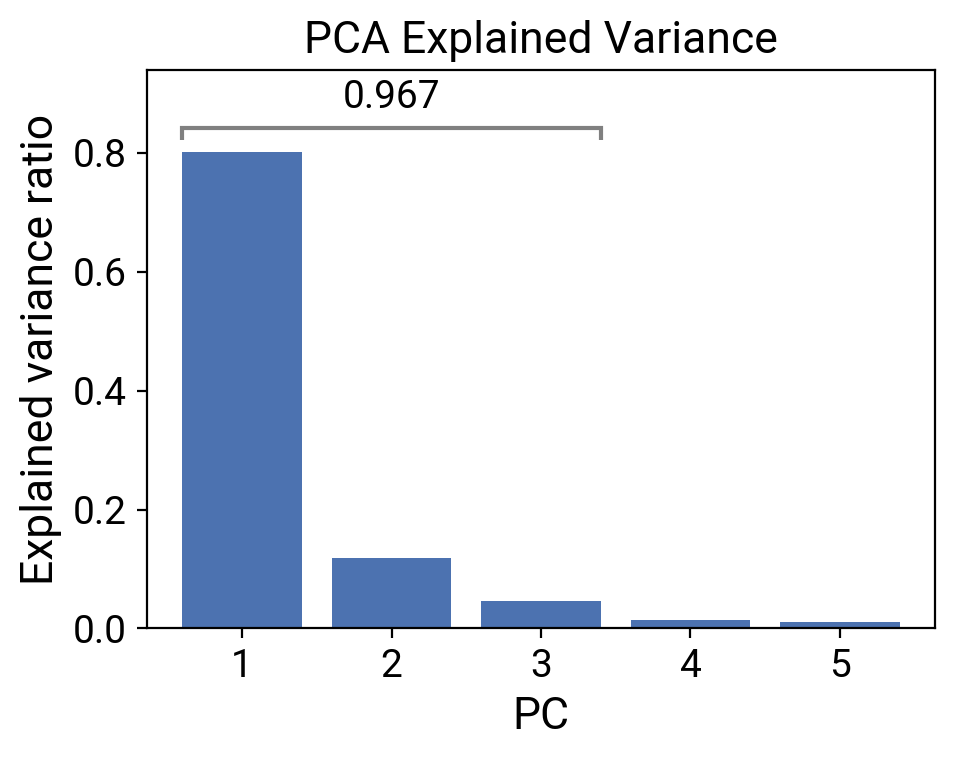

In [8]:
import matplotlib.patches as patches
from matplotlib.path import Path

n_components = DEFAULT_PCA_PREPROCESS_KWARGS['pca_kwargs']['n_components']
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar(range(1, n_components + 1), pca.explained_variance_ratio_)

ax.set_xticklabels(range(1, n_components+1))
ax.set_xticks(range(1, n_components+1))
ax.set_xlabel("PC")
ax.set_ylabel("Explained variance ratio")

top_n = 3

sum_top_n = pca.explained_variance_ratio_[:top_n].sum() 

# Draw a custom curly brace (half bracket) above the top 3 bars
brace_height = max(pca.explained_variance_ratio_[:top_n]) + 0.02  # Slightly higher to clear the bars
brace_x_start = 1 - 0.4  # Slightly before the first bar
brace_x_end = 3 + 0.4   # Slightly past the third bar

# Define the points for the path (a simple upside-down half-bracket)
vertices = [
    (brace_x_start, brace_height),  # Left bottom of the brace
    (brace_x_start, brace_height + 0.02),  # Left top of the brace
    (brace_x_end, brace_height + 0.02),  # Right top of the brace
    (brace_x_end, brace_height),  # Right bottom of the brace
]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO]

path = Path(vertices, codes)
patch = patches.PathPatch(path, facecolor='none', lw=1.5, edgecolor='gray')
ax.add_patch(patch)

# Annotation for the brace
ax.annotate(f"{sum_top_n:.3f}", 
            ((brace_x_start + brace_x_end) / 2, brace_height + 0.04),  # Position for the text
            textcoords="data",
            ha="center", va="bottom", fontsize=14)
ax.set_title("PCA Explained Variance")

ax.set_ylim([0.0, 0.94])

plt.tight_layout()

plt.show()

Visualize the PCA component matrix

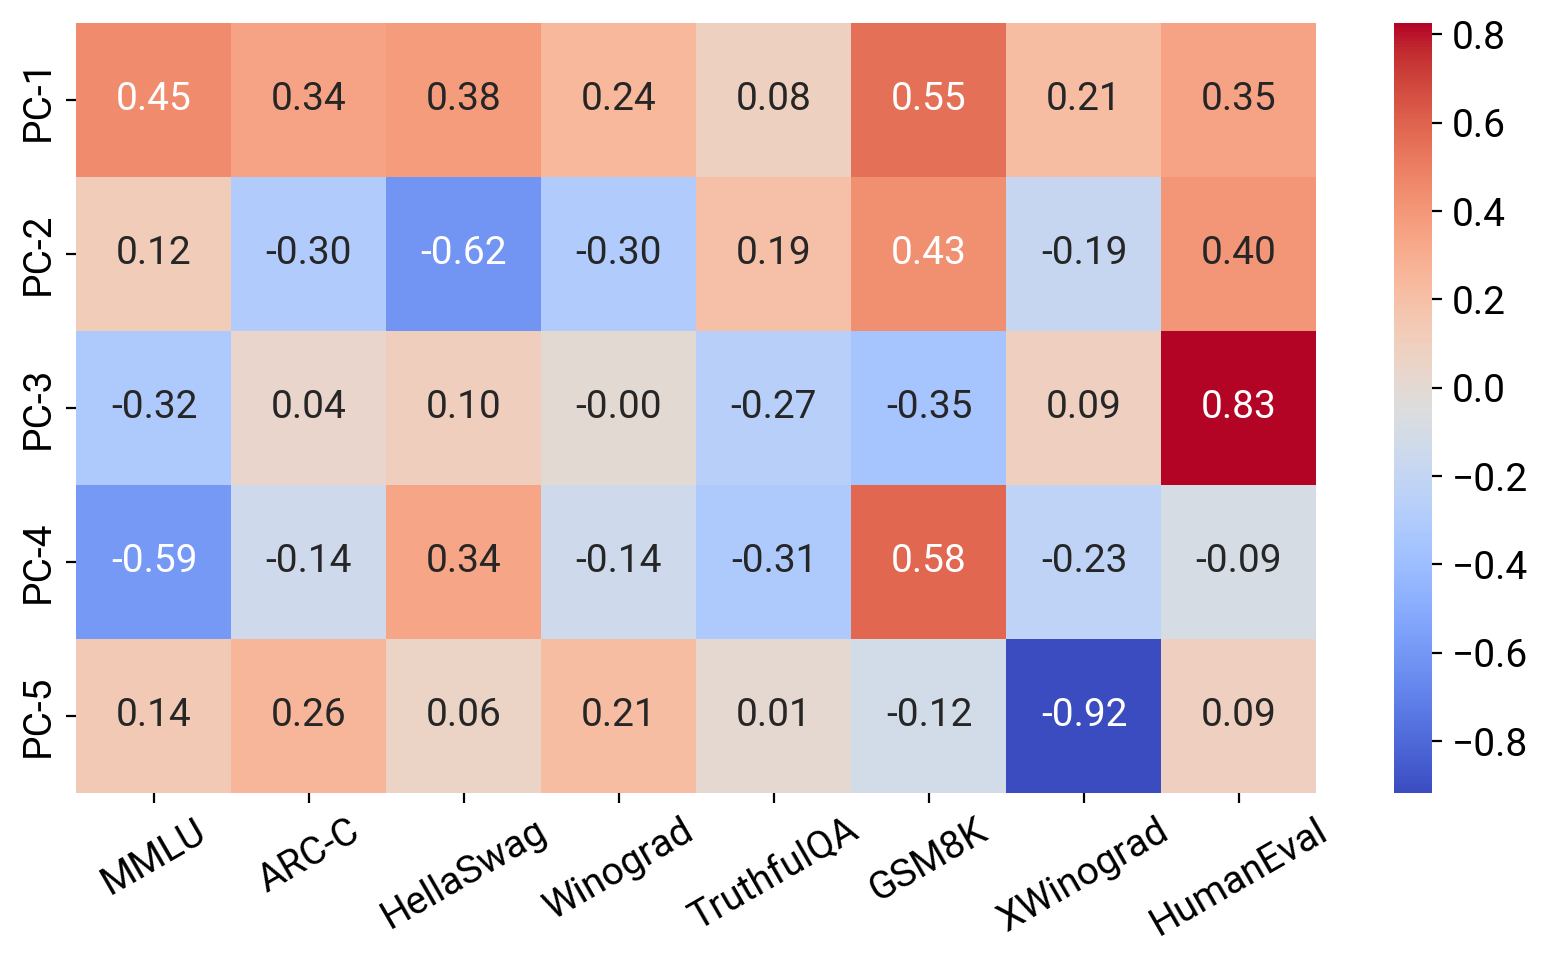

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

# nicer visualization: make the PC dims mostly "postively" correlated to model performance
vis_weights = pca.components_.copy()
for idx in [1, 3, 4]:
    vis_weights[idx] *= -1

sns.heatmap(vis_weights, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_yticklabels(imputed_metric_pc.columns)
ax.set_xticklabels(ALL_BENCHMARK_METRIC_LIST, rotation=30)

plt.show()

## Scaling Analysis (Per Model Family)

In [10]:
PLOT_COMPARABLE_FLOPS_MODEL_FAMILY = [
    'Llama-2',
    'Llama',
    'Qwen1.5',
    'Qwen',
    'Falcon',
    'Pythia',
    'BLOOM',
    'GPT-Neo/J',
    'OPT',
    'XGLM',
    'StarCoder',
    'CodeLlama',
]

Log-linear correlation between PC-1 and FLOPs

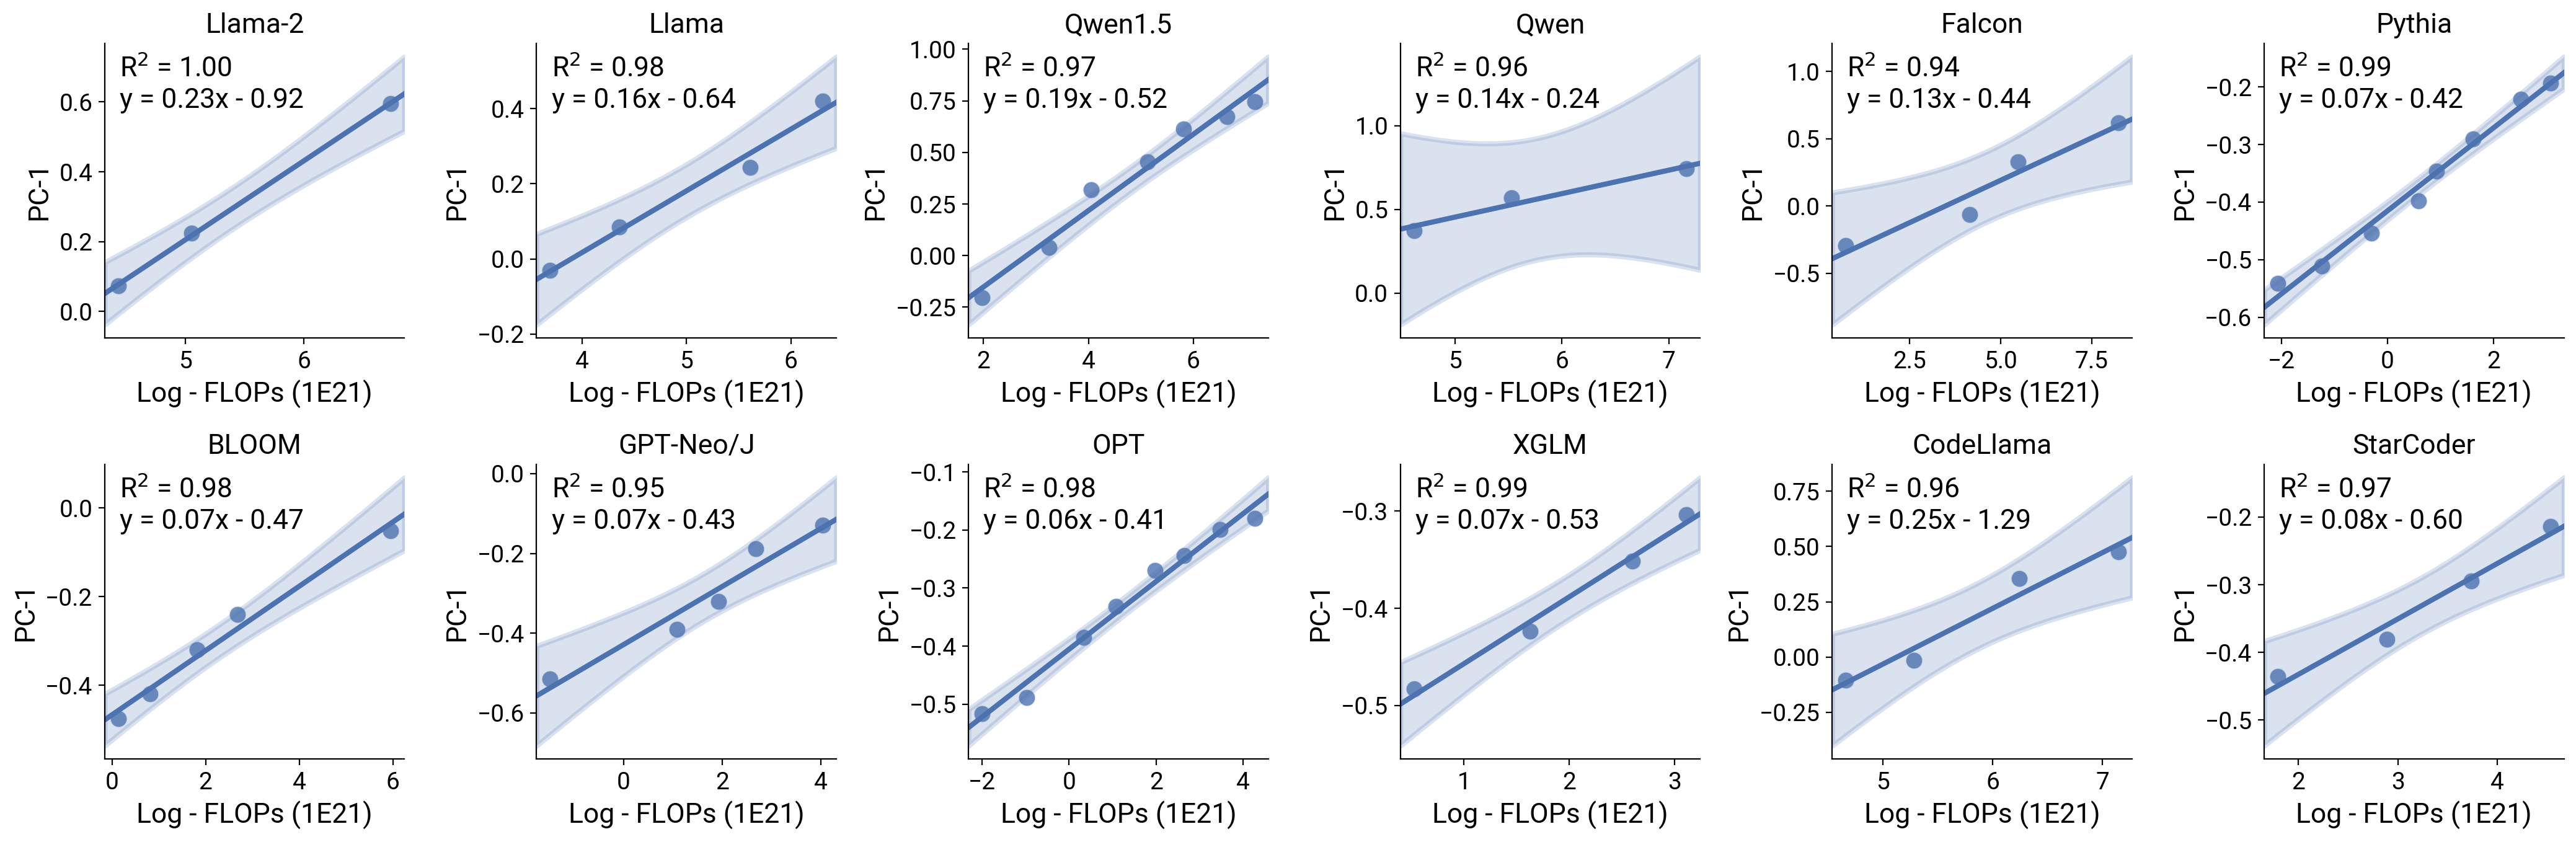

In [11]:
fig = plot_linear_correlation(
    base_llm_eval_pca, 'FLOPs (1E21)', 'PC-1', 
    PLOT_COMPARABLE_FLOPS_MODEL_FAMILY, log_x_metric=True, num_cols=6
)

Log-linear correlation between lowe-ranked PCs and FLOPs

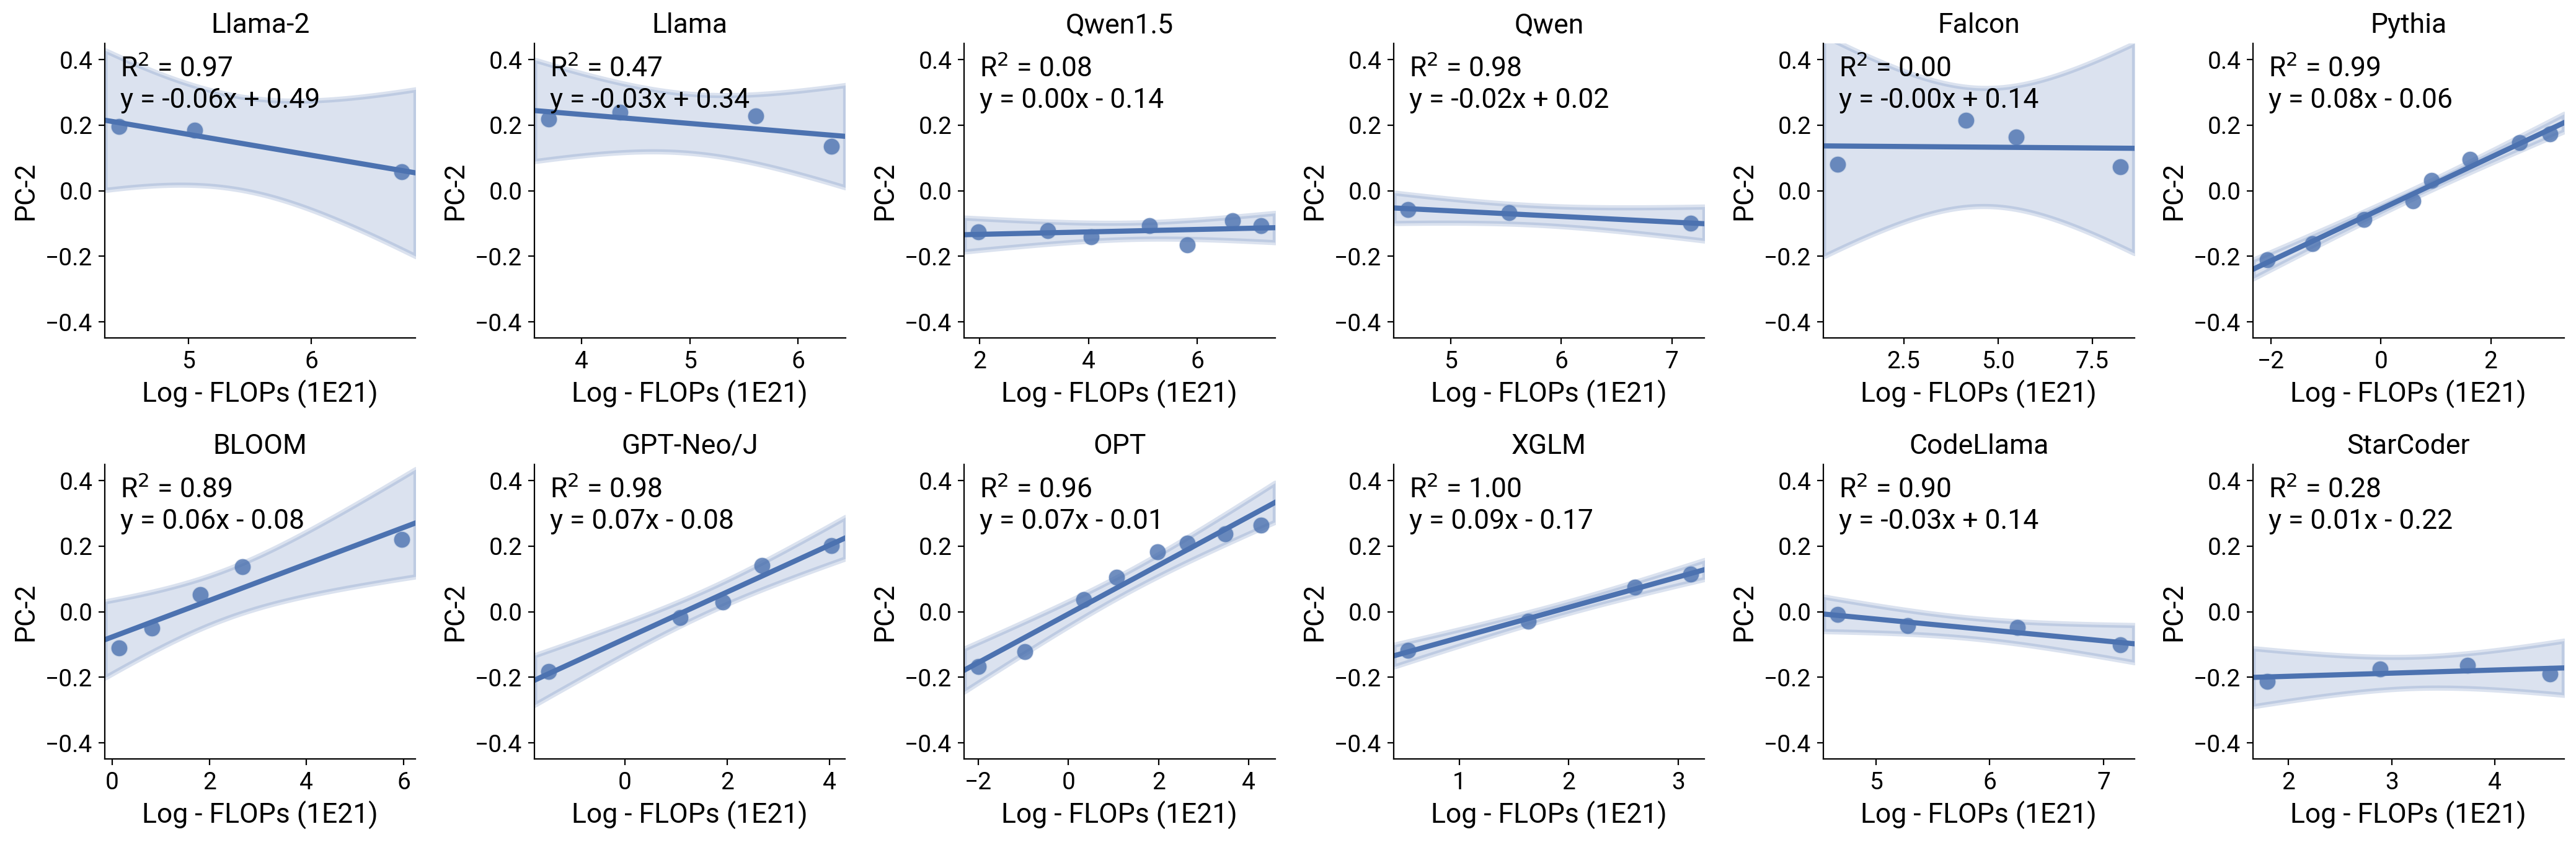

In [12]:
fig = plot_linear_correlation(
    base_llm_eval_pca, 'FLOPs (1E21)', 'PC-2', 
    PLOT_COMPARABLE_FLOPS_MODEL_FAMILY, log_x_metric=True, 
    num_cols=6, ylim=[-0.45, 0.45]
)

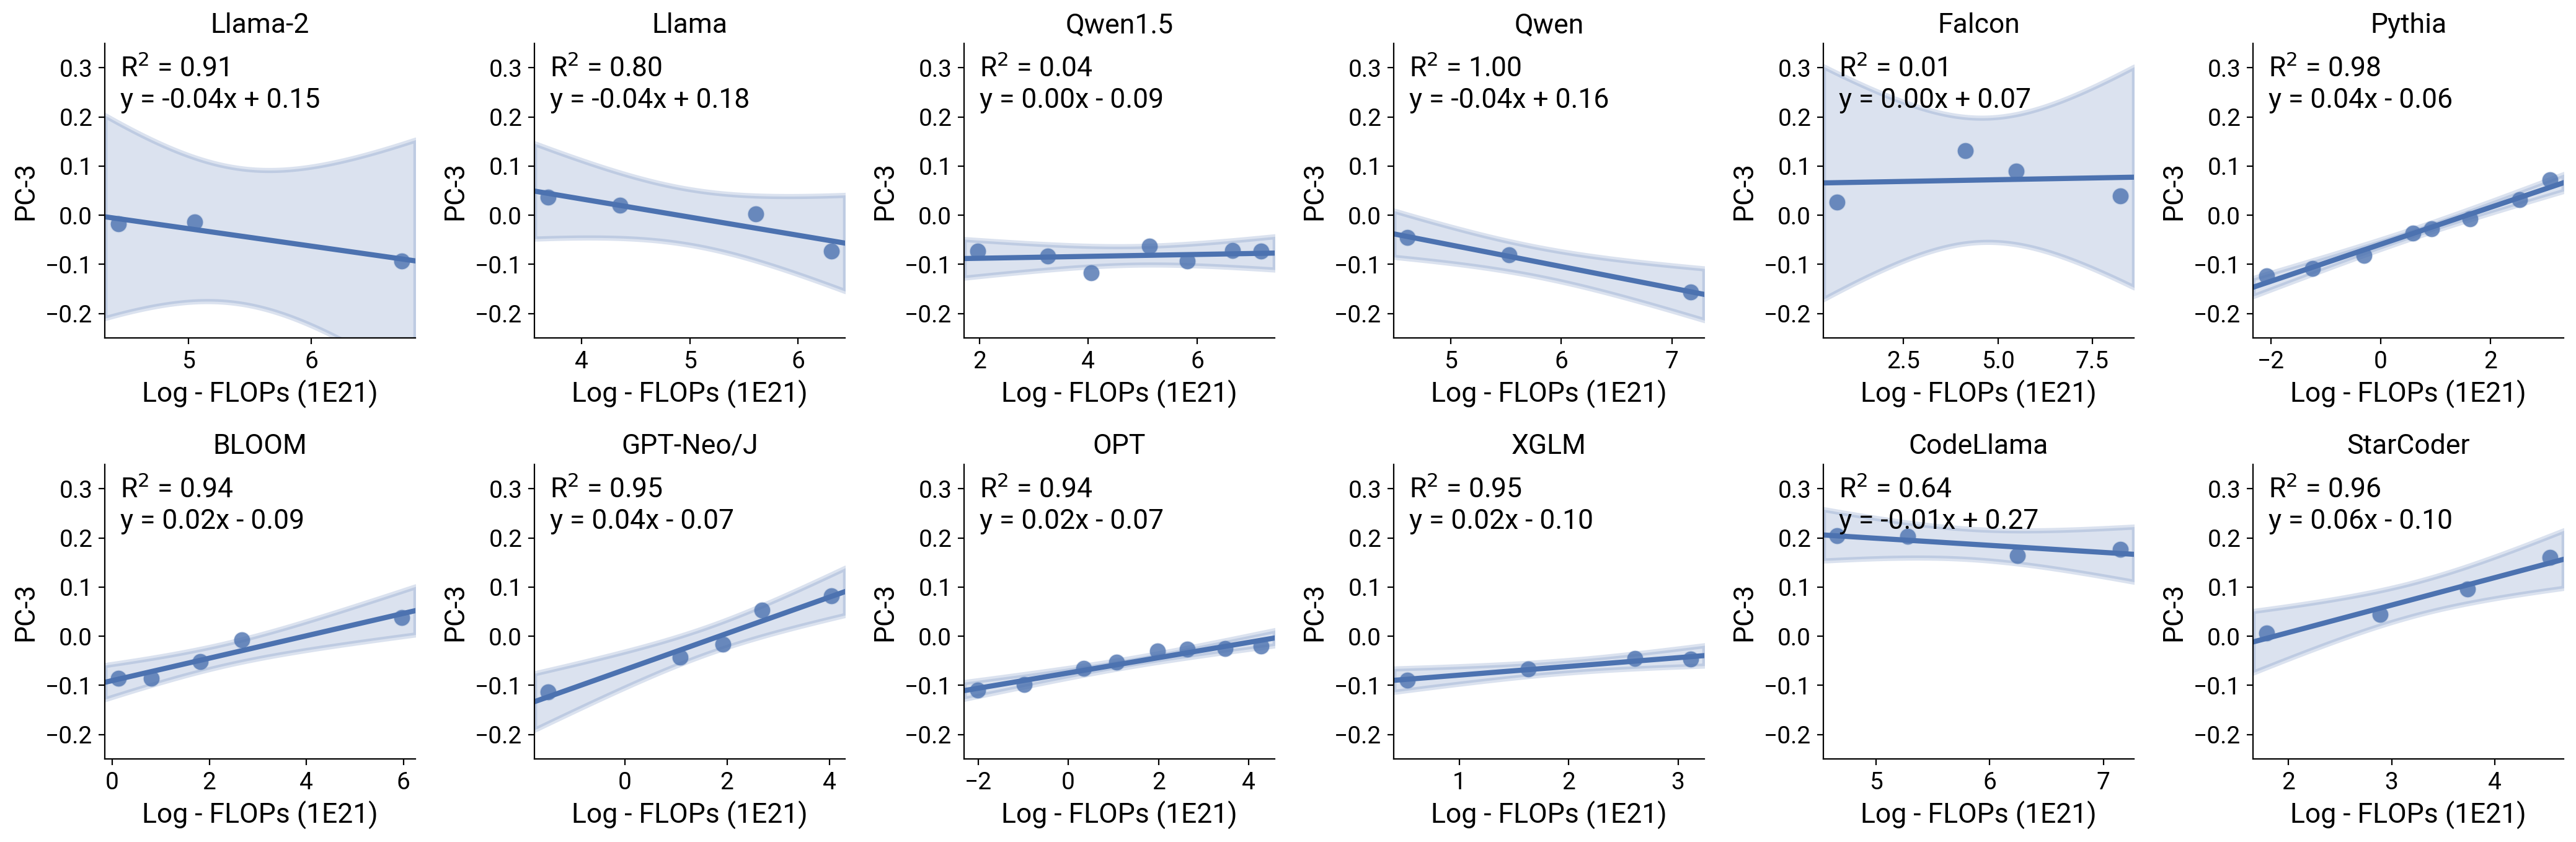

In [13]:
fig = plot_linear_correlation(
    base_llm_eval_pca, 'FLOPs (1E21)', 'PC-3', 
    PLOT_COMPARABLE_FLOPS_MODEL_FAMILY, log_x_metric=True, 
    num_cols=6, ylim=[-0.25, 0.35]
)

## Scaling Analysis (Cross Model Family)

In [14]:
# No public information on training FLOPs
NA_MODEL_FAMILY = [
    "Mistral",
    "Mixtral",
]

PC-1 vs training FLOPs for all model families

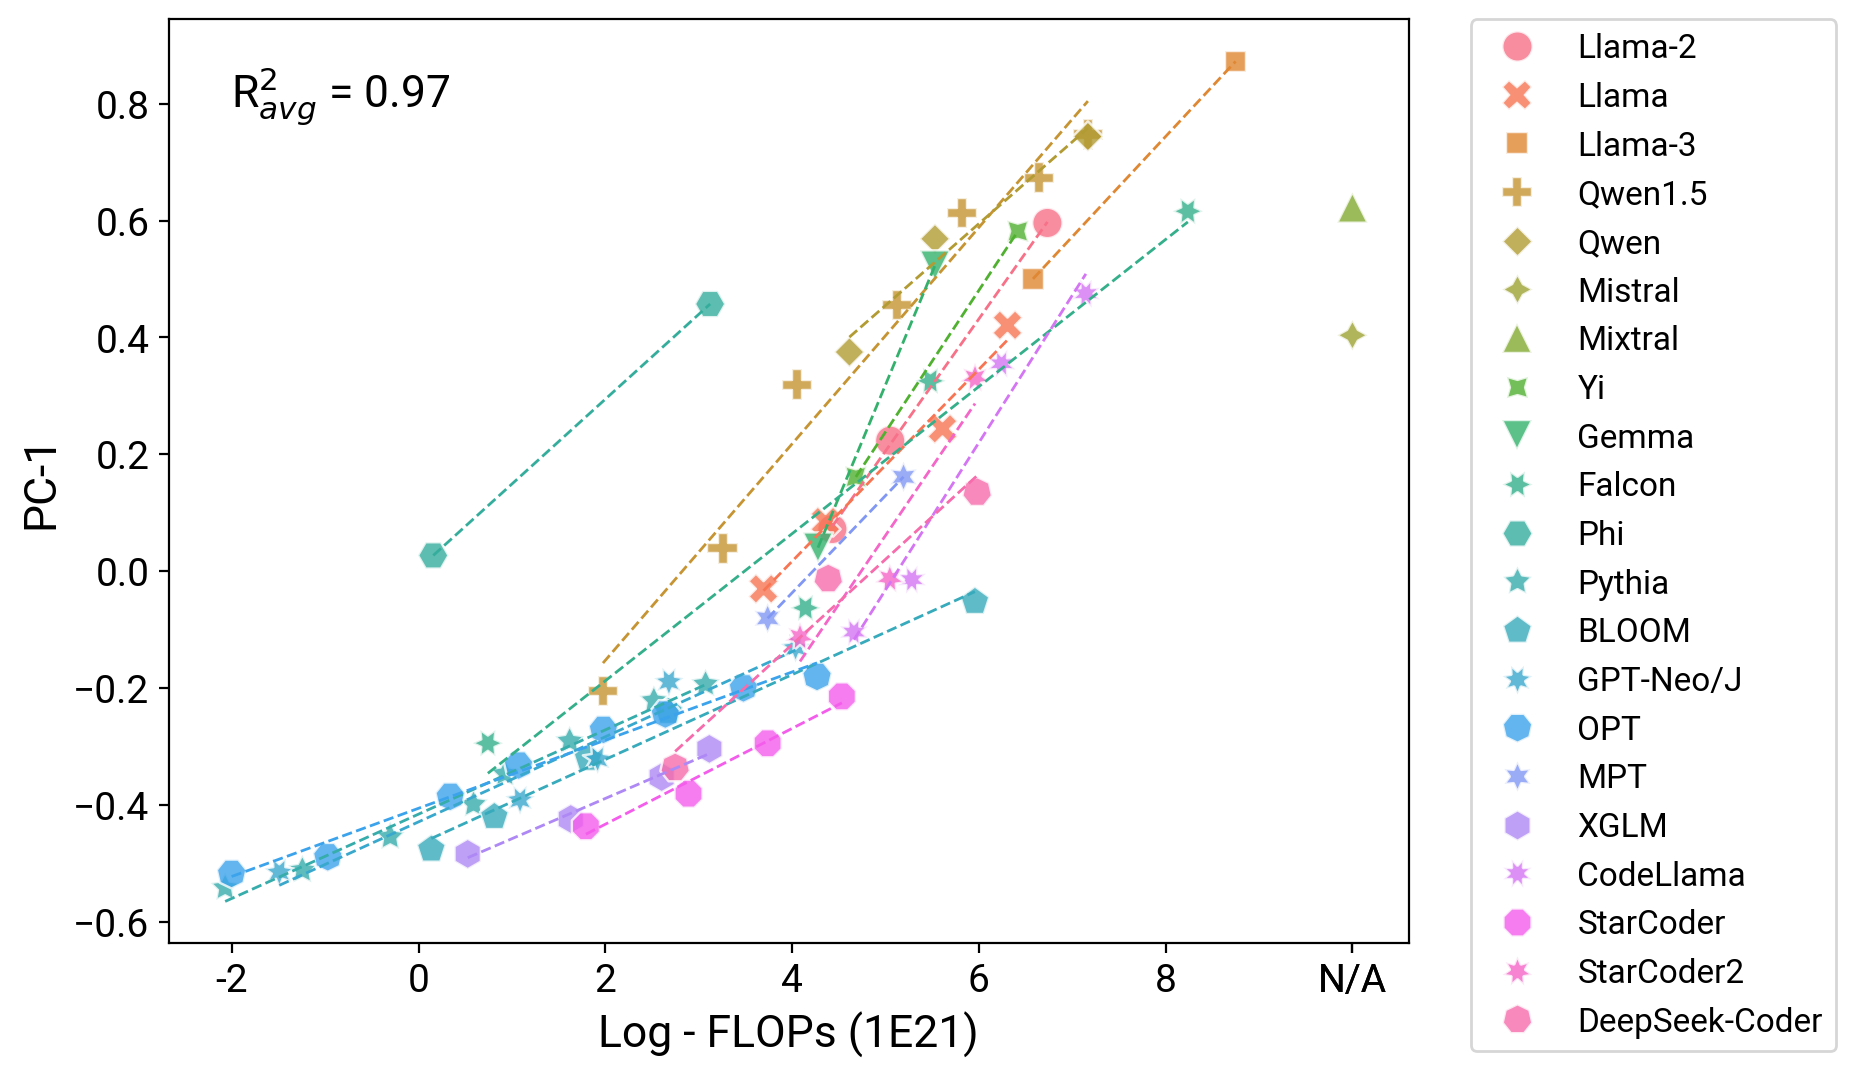

In [15]:
fig = plot_linear_correlation(
    base_llm_eval_pca, 'FLOPs (1E21)', 'PC-1', 
    EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES, log_x_metric=True, unified_plot=True,
    na_model_family_names=NA_MODEL_FAMILY
)

Benchmark metric vs training FLOPs for all model families

/Users/yangjunruan/Project/VSCodeProject/ObsScaling-Private/utils/plot.py:1185: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(x_metric_df, y_metric_df)
/Users/yangjunruan/Project/VSCodeProject/ObsScaling-Private/utils/plot.py:1186: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(x_metric_df, y_metric_df)
/Users/yangjunruan/Project/VSCodeProject/ObsScaling-Private/utils/plot.py:1194: RuntimeWarning: invalid value encountered in scalar divide
  r2 = 1 - np.sum((y_metric_df - pred_y_metric_df)**2) / np.sum((y_metric_df - np.mean(y_metric_df))**2)


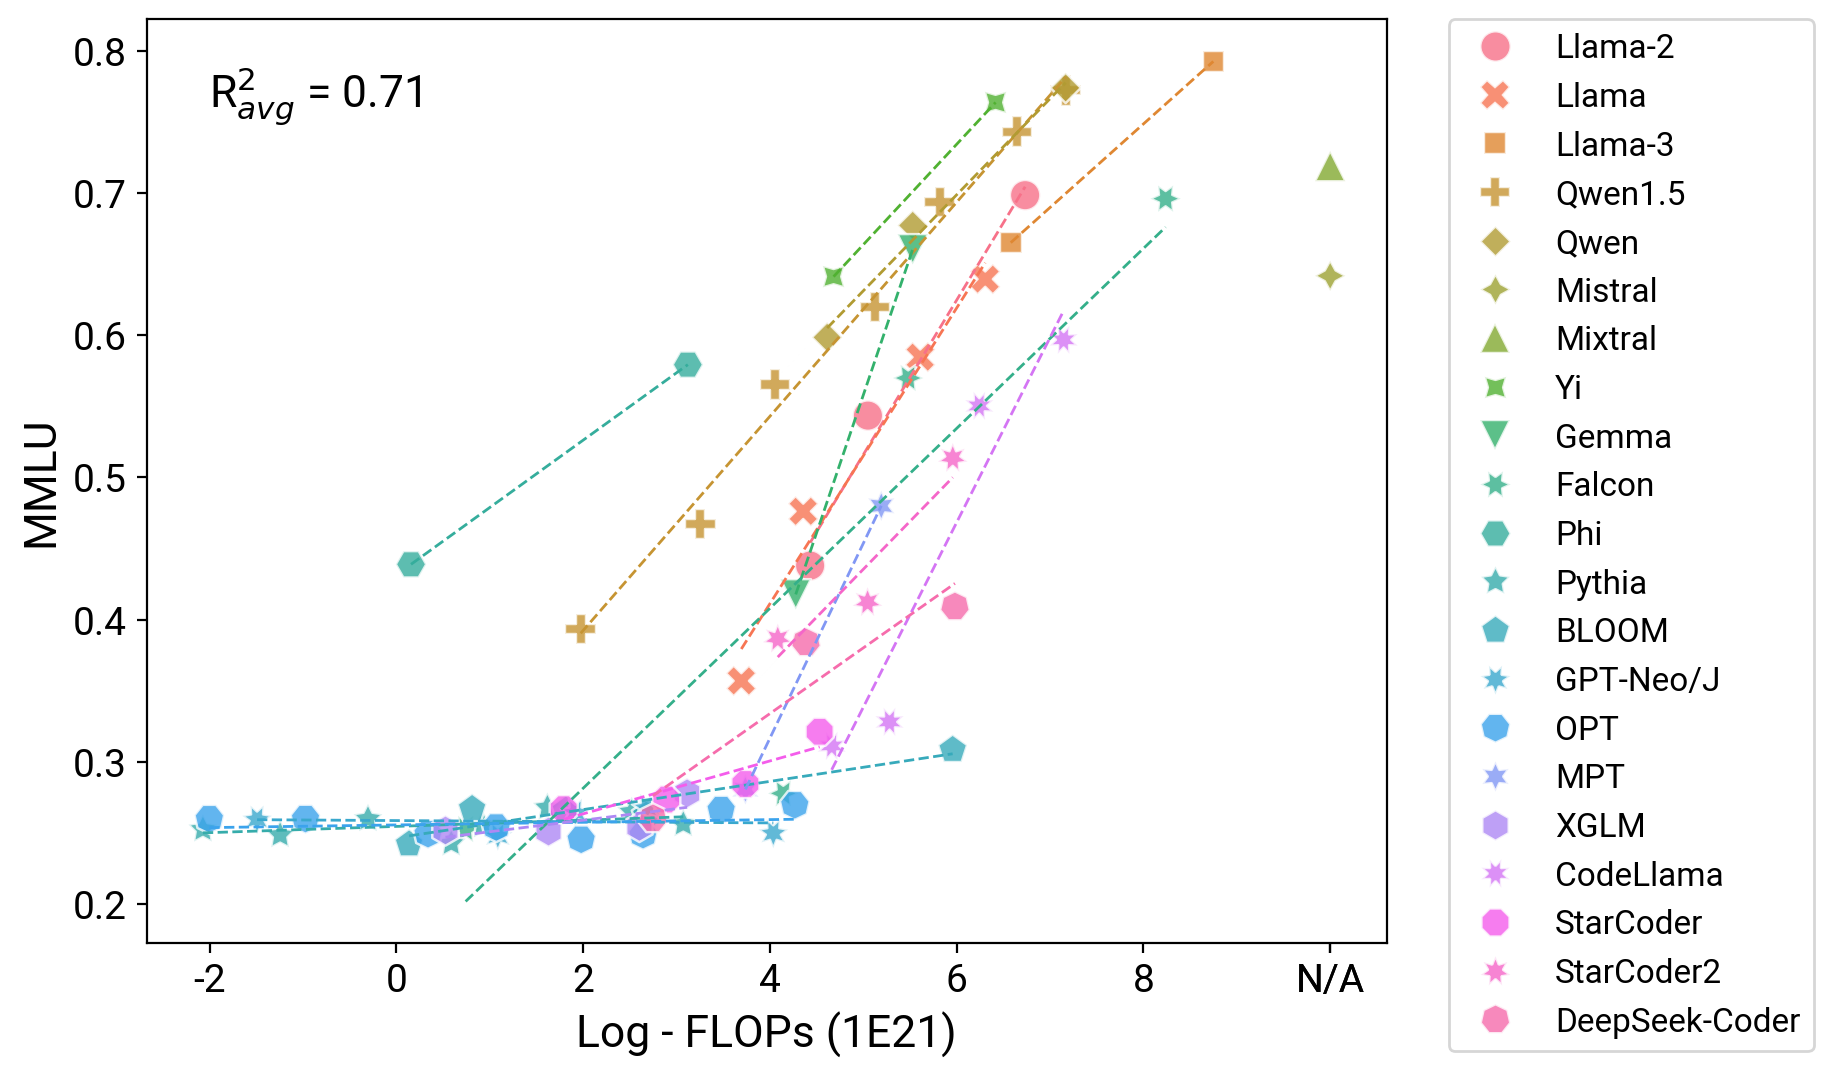

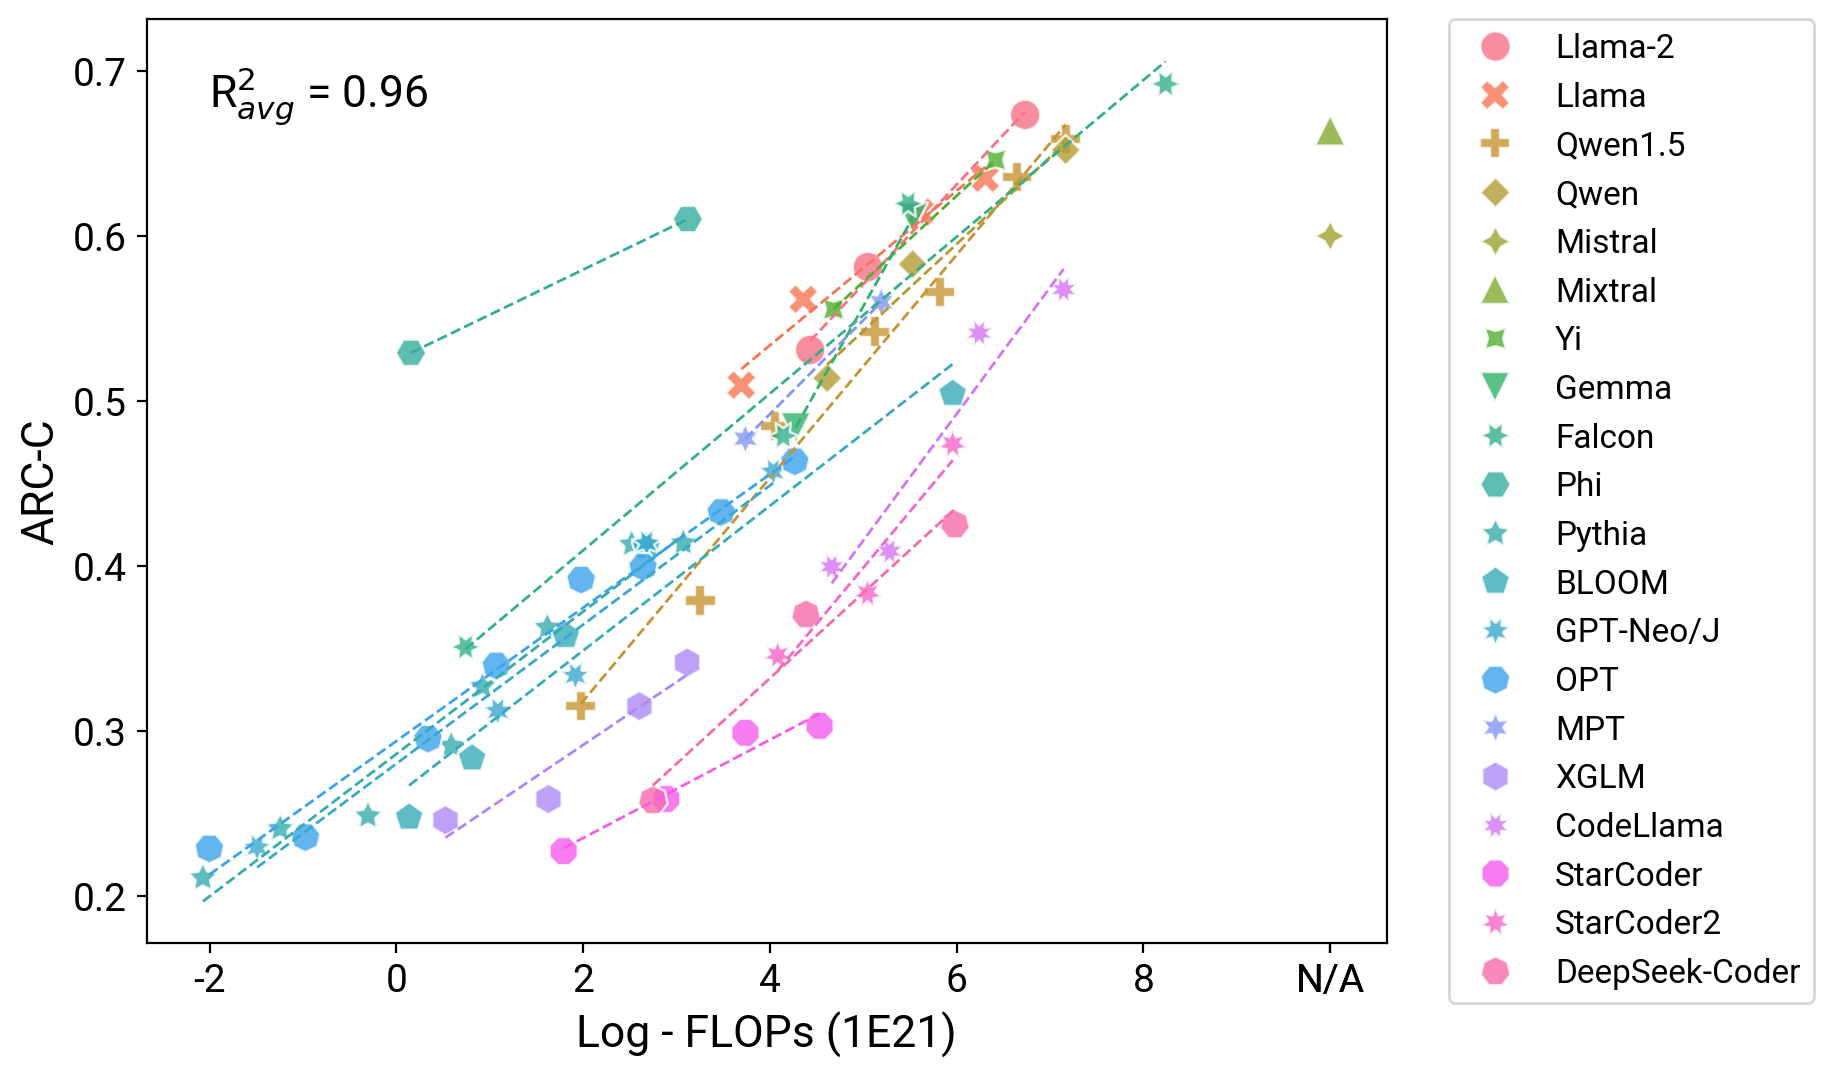

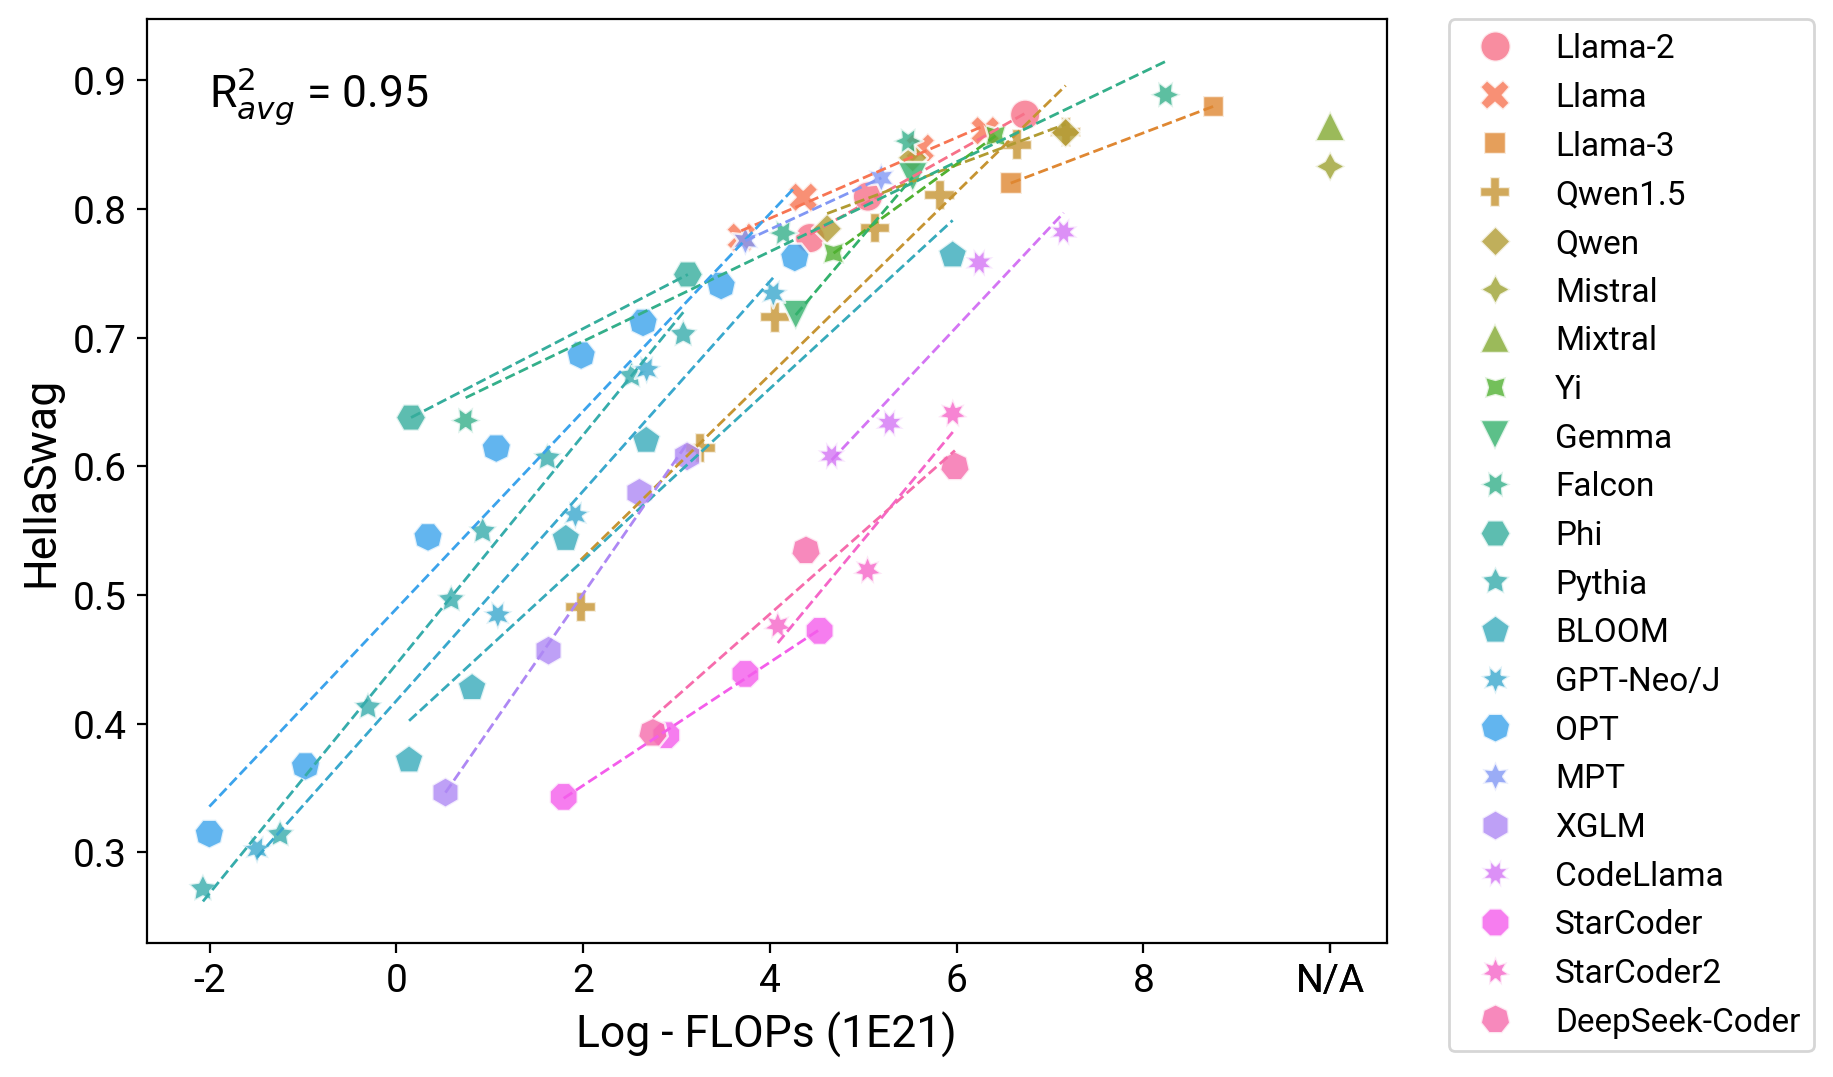

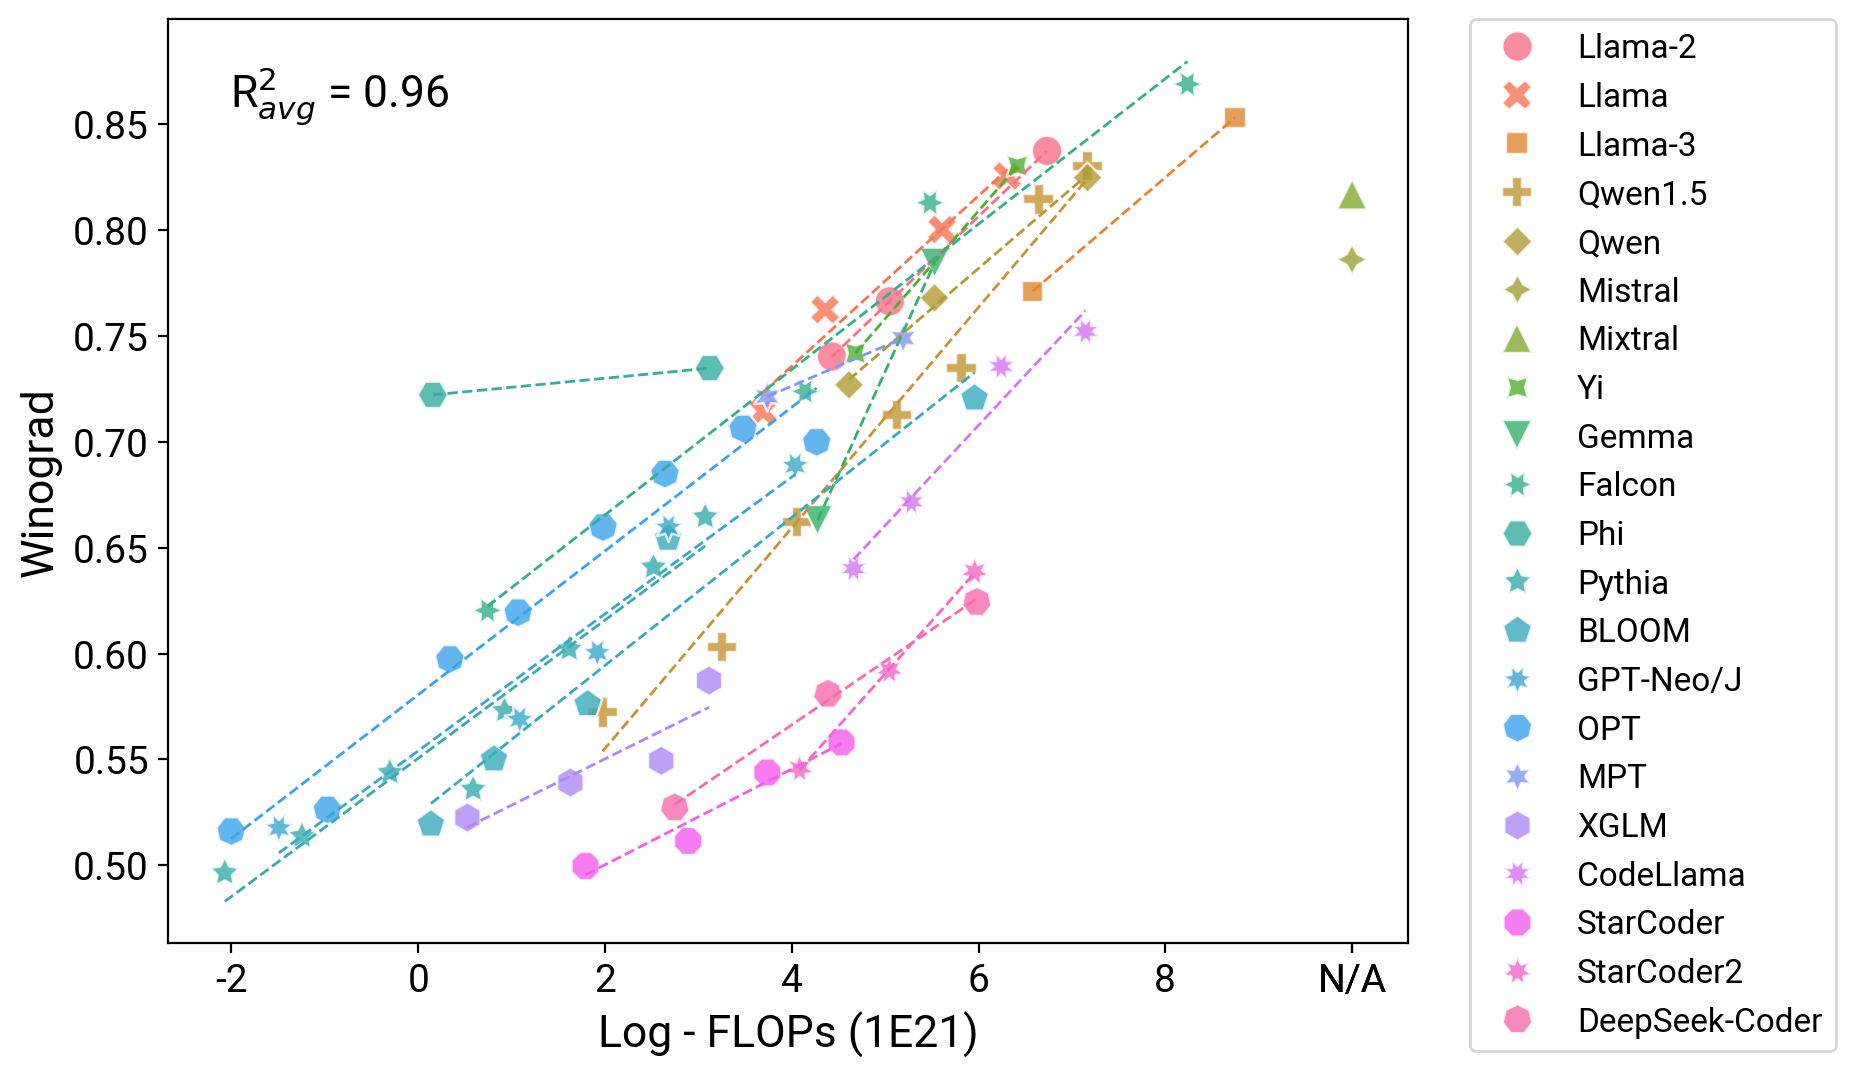

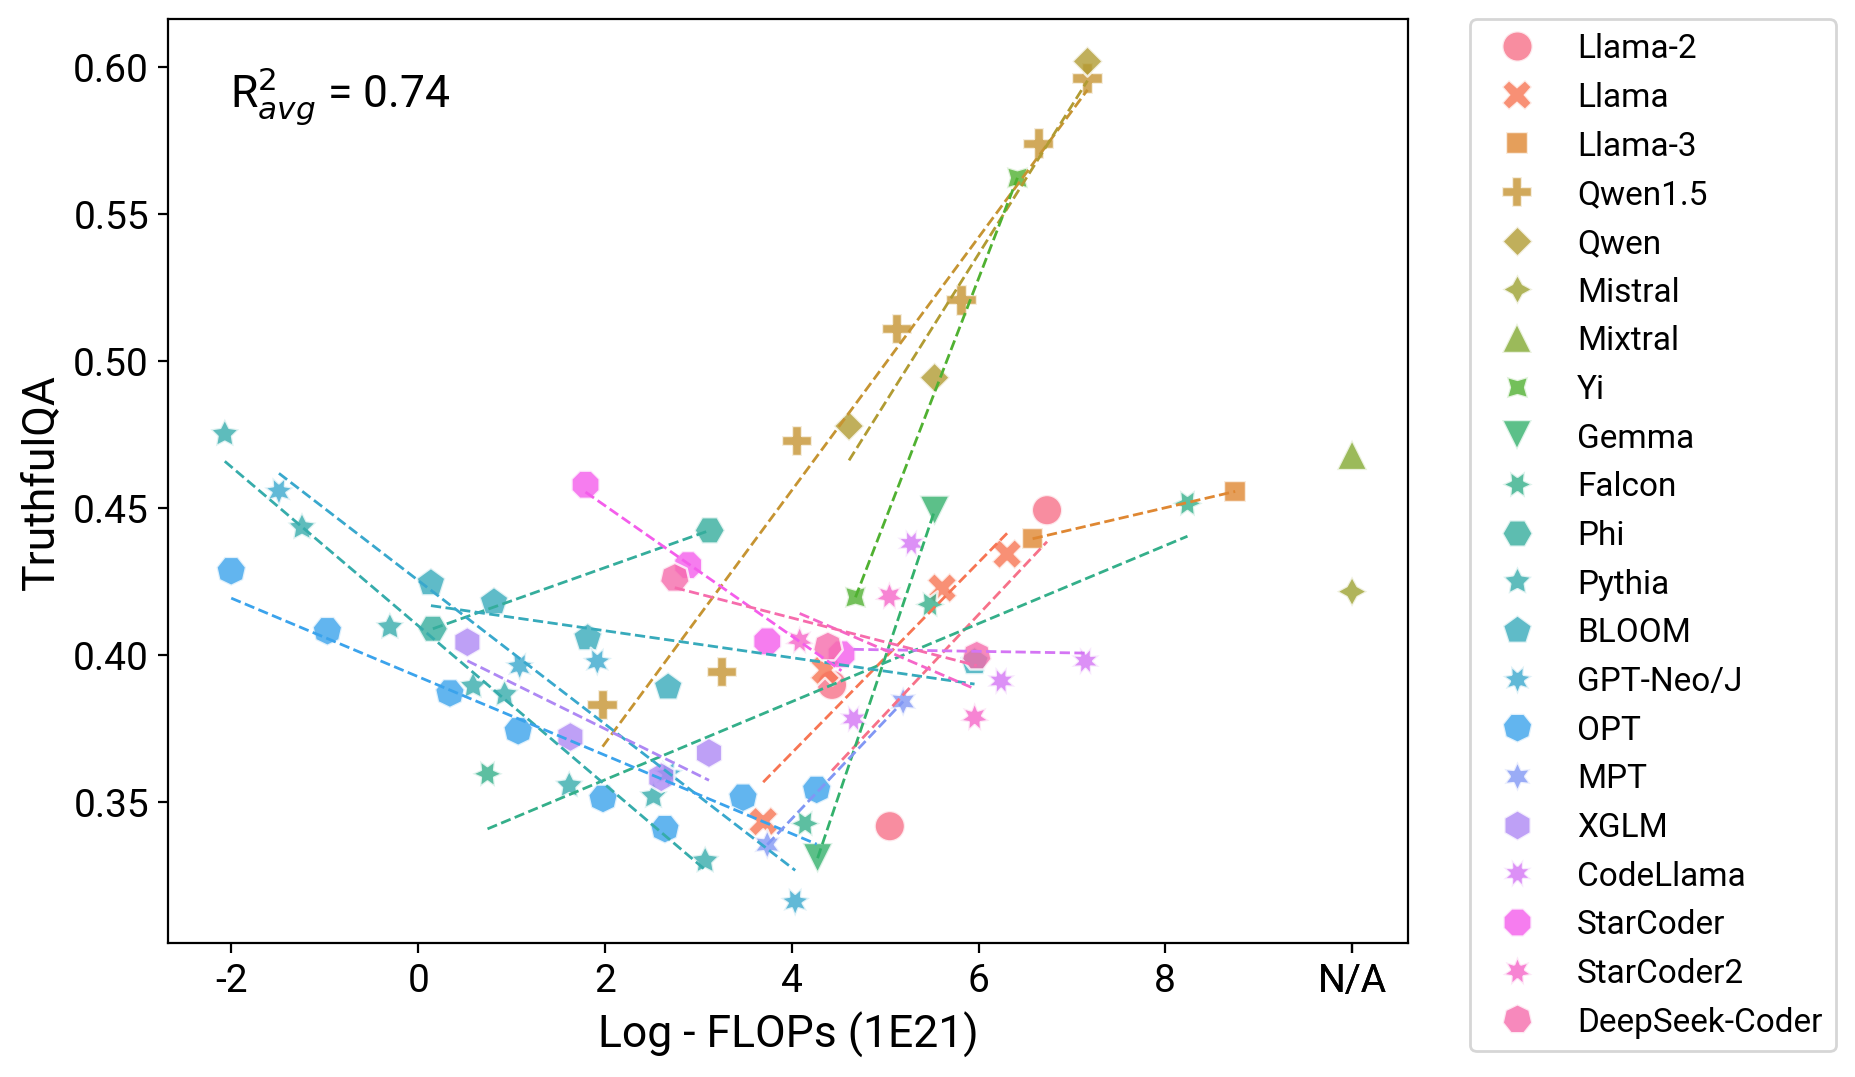

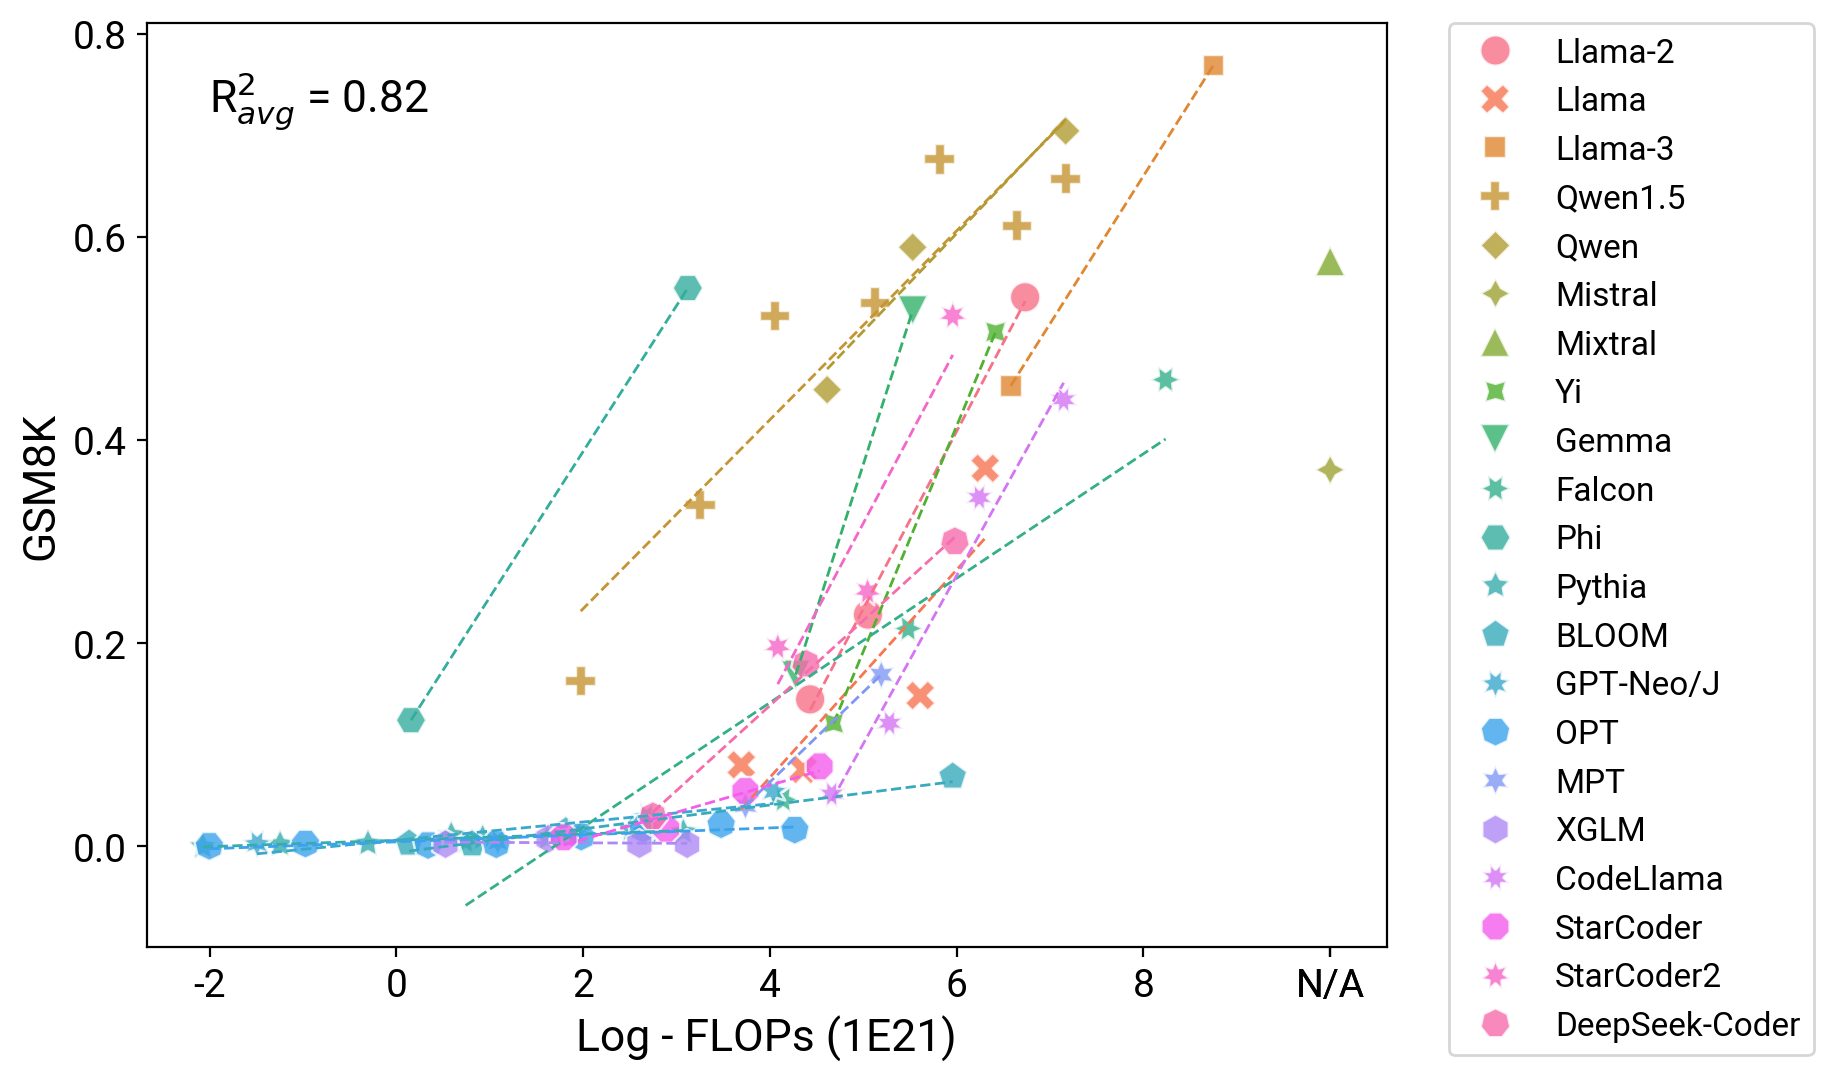

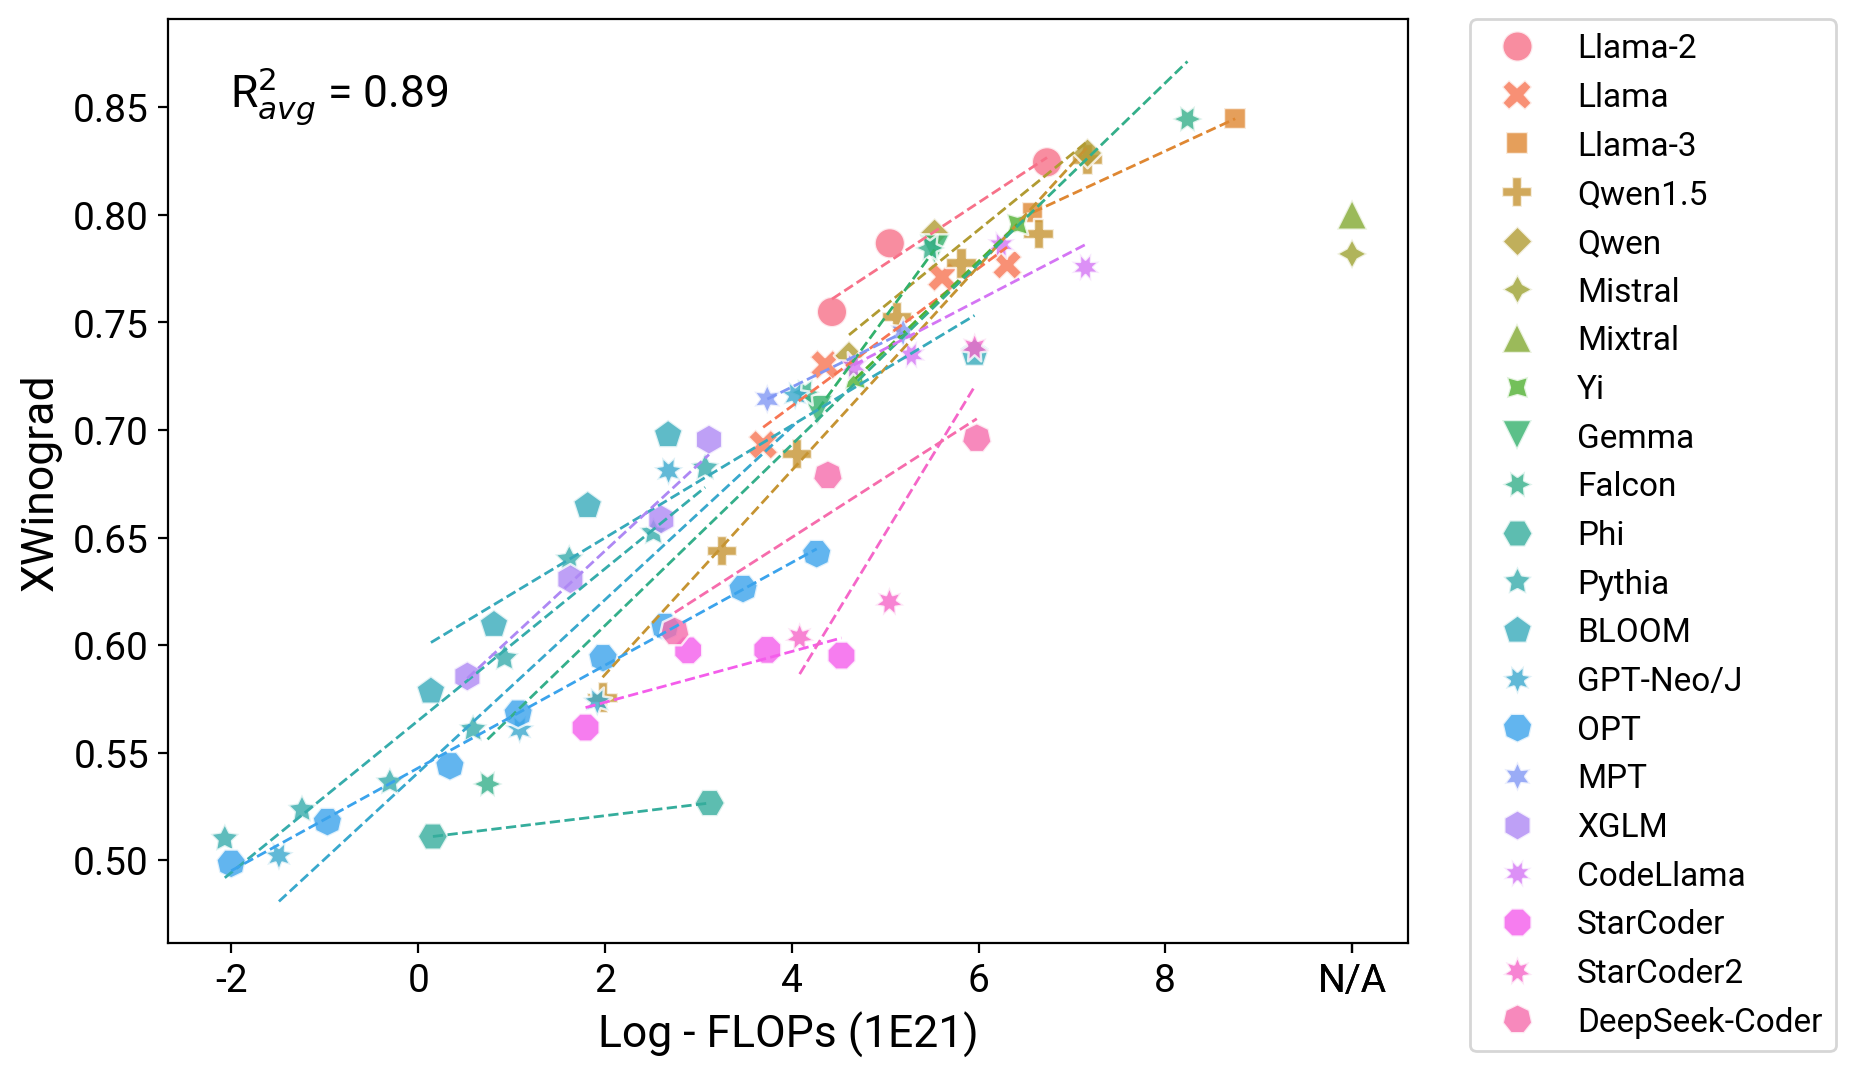

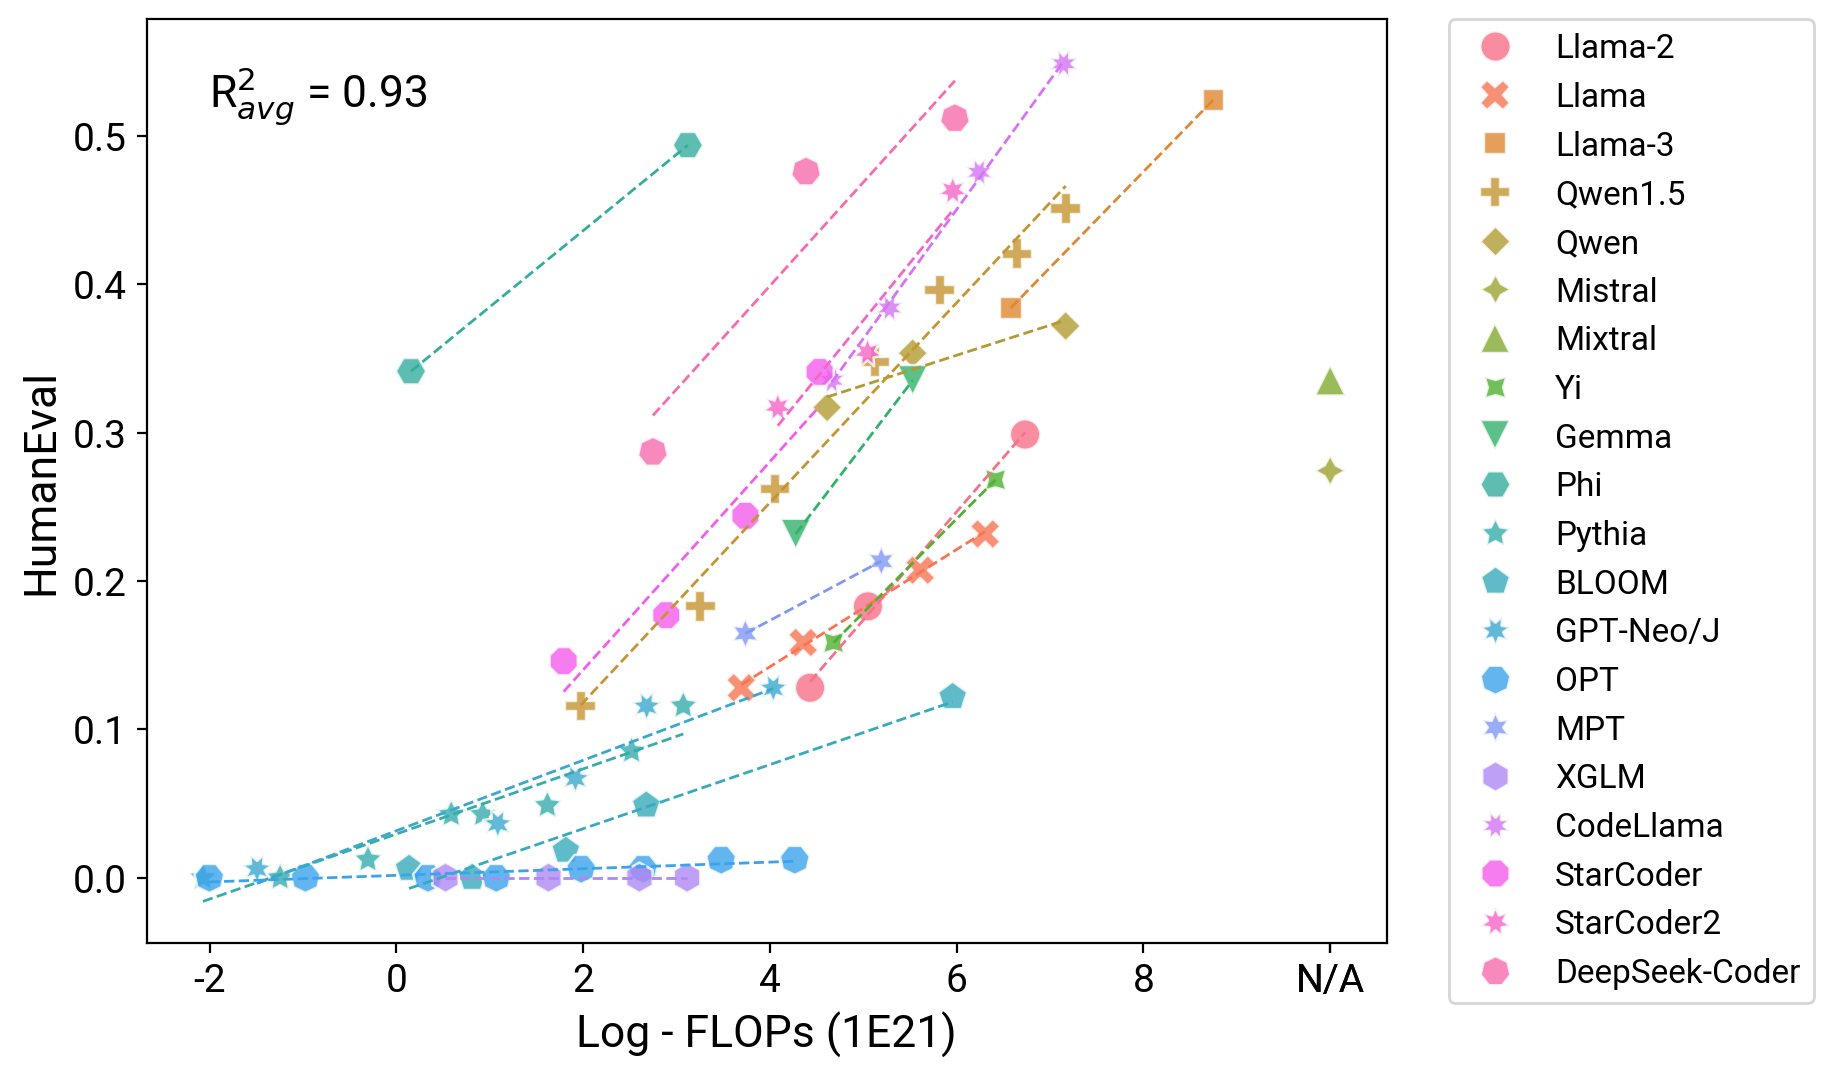

In [16]:
x_metric_name = 'FLOPs (1E21)'

for y_metric_name in ALL_BENCHMARK_METRIC_LIST:

    _base_llm_eval_pca = base_llm_eval_pca.dropna(subset=[y_metric_name])
    fig = plot_linear_correlation(
        _base_llm_eval_pca, x_metric_name, y_metric_name, 
        EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES, log_x_metric=True, unified_plot=True,
        na_model_family_names=NA_MODEL_FAMILY
    )